<a href="https://colab.research.google.com/github/Ohm-T/Unsupervised-Classification/blob/main/Project_2_Analysis_of_handwritten_signatures_for_identity_verification_identity_verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## <font color='red'>**TODOLIST** </font>


*   Attention fichier à importer selon drive pour data et dans fichier serveur pour complexité

*   1er pb lors de la convertion ',' to '.' des fichiers pour 24G erreur a la fin de compilation (derniere ligne cellule 3) car fichier 24G pas de TAB

* DBSCAN à analyser, comment définir paramètre ?
Nombre de cluster optimal? On ne peut pas definir nombre de clusters

* Faire plus de figures pour vraiment analyser les differentes situations

* Clean le code pour que ça soit plus clair

* ((Régler pb couleur a la fin))


---
# <font color='ForestGreen'> PROJET 2 </font>
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
## <font color='LimeGreen'>1.   Data vizualisation 🌍 </font>

In [3]:
# Importer fichier dans gg colab
file_4G = 'Complexité avec 4G (100x25).txt'
file_8G = 'Complexité avec 8G (100x25).txt'
file_24G = 'Complexité avec 24G (100x25).txt'
signatures = ['Signature {}'.format(i) for i in range(1,26)]

# Données de complexité
complex_4G = pd.read_table(file_4G, header=None)
complex_8G = pd.read_table(file_8G, header=None)
complex_24G = pd.read_table(file_24G, header=None)

complex_4G.columns = signatures
complex_8G.columns = signatures
complex_24G.columns = signatures

# Réglé : pb de str avec , => to float avec .
try:
  for i in complex_4G.columns:
    complex_4G[i] = complex_4G[i].str.replace(',', '.').astype(float)
    complex_8G[i] = complex_8G[i].str.replace(',', '.').astype(float)
    complex_24G[i] = complex_24G[i].str.replace(',', '.').astype(float)

except Exception:
    pass
    print("ignored the exception")


ignored the exception


In [5]:
complex_24G.head()

,Signature 1,Signature 2,Signature 3,Signature 4,Signature 5,Signature 6,Signature 7,Signature 8,Signature 9,Signature 10,Signature 11,Signature 12,Signature 13,Signature 14,Signature 15,Signature 16,Signature 17,Signature 18,Signature 19,Signature 20,Signature 21,Signature 22,Signature 23,Signature 24,Signature 25
0,19.418379,21.168041,17.978114,20.349810,18.958750,17.880597,20.276367,23.207289,19.794416,19.319806,19.040742,19.107257,19.372960,20.761771,20.443187,18.574054,17.278135,19.541206,17.414797,20.118963,17.522062,20.535226,17.915963,19.754014,17.689681
1,23.891532,21.410094,22.217169,19.488479,21.591756,25.032245,23.598878,24.555337,22.085059,25.036497,22.762188,22.807787,24.656660,23.006744,21.215481,22.905254,23.247706,22.164662,21.523057,21.123666,21.441618,23.195070,20.844714,23.126296,21.378493
2,26.781532,27.125942,26.783903,26.252523,26.571913,27.578733,26.430292,26.166015,26.725454,26.996119,26.310383,26.986084,25.352634,26.419390,26.850359,26.402912,27.805016,27.250634,27.027102,27.148904,26.513630,26.352621,26.475316,26.158157,25.317402
3,25.570153,23.337583,26.074787,23.298449,23.013962,25.097759,23.964793,26.672919,26.146179,25.818987,25.940086,25.081272,26.095806,26.244383,25.381787,25.172487,26.135858,25.322893,25.230605,25.515222,24.485672,26.171534,25.472147,26.057215,25.046337
4,19.803114,22.290674,22.967518,21.656370,21.557347,24.588345,24.913413,25.045552,22.836658,23.619319,23.675137,21.064089,23.161481,23.183328,24.490852,22.865086,22.900575,22.795431,23.715837,24.535791,22.223535,24.457346,23.373926,24.337768,23.433979


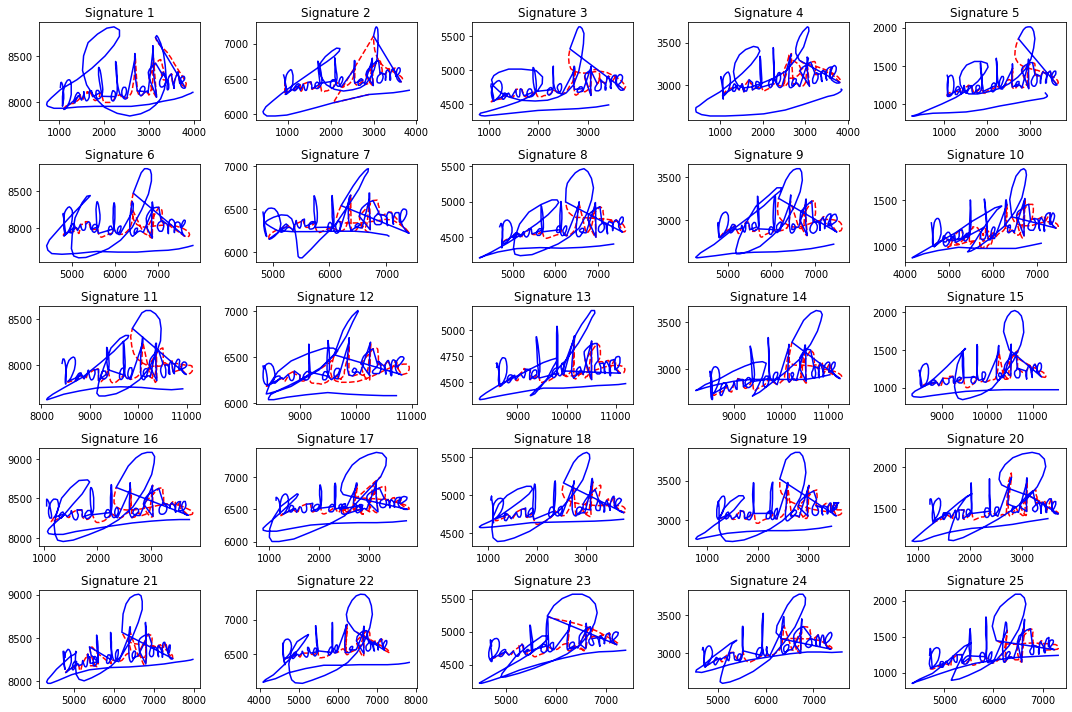

In [6]:
# Données signatures
fig, axes = plt.subplots(5,5, figsize=(15,10))
for i,ax in enumerate(axes.flat):
  dt = pd.read_table('drive/MyDrive/Colab/Handwritten_sig/BD/2v{}.txt'.format(i), sep=' ', header=None)
  dt.columns = ['X', 'Y', 'P', 'Az', 'Al']
  dt_air = dt[dt['P'] == 0 ]
  dt_feuille = dt[dt['P'] != 0 ]
  ax.plot(dt_air['X'], dt_air['Y'], "r--")
  ax.plot(dt_feuille['X'], dt_feuille['Y'], "b")
  ax.set_title('Signature {}'.format(i+1))

#fig.suptitle('Signatures de la première personne', fontsize=16)
fig.tight_layout()

plt.show()
  

---
## <font color='LimeGreen'> 2.   Experimental work ⛑ </font>
- A - Classification non-supervisées des personnes pour analyser l’apport de la mesure de complexité
- B - Classification non-supervisées des signatures (writer-independent)
- C - Apprentissage et généralisation



---


### <font color='PaleGreen'> A - Classification non-supervisées des personnes pour analyser l’apport de la mesure de complexité </font>

In [4]:
# Mesure de complexité moyenne par personne sur les 25 signatures pour NG = 4
mean4 = complex_4G.mean(axis=1)
# Mesure de complexité moyenne sur les 25 signatures pour NG = 8
mean8 = complex_8G.mean(axis=1)

# Mesure de complexité moyenne sur les 25 signatures pour NG = 24
mean24 = complex_24G.mean(axis=1)

#Dataframe des moyennes
mean_complexity = pd.DataFrame({'4G': mean4,'8G':mean8,'24G':mean24})
mean_complexity.head(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  after removing the cwd from sys.path.


,4G,8G,24G
0,33.196174,29.089110,19.336863
1,29.986983,27.738042,22.572258
2,30.667706,29.347793,26.631319
3,31.983777,29.137399,25.293955
4,28.689045,26.999809,23.179699
5,30.716722,29.220561,26.713651
6,29.552929,28.779939,24.927115
7,28.392685,26.220018,19.673326
8,29.181635,28.539514,25.571022
9,31.040593,29.062635,24.102158



**Remarque :** Nous connaissons le nombre de clusters que l'on souhaite avoir ainsi les méthodes kmeans, kmedoid, méthode par modèle (avec implémentation de l'EM) semblent à première vu une bonne approche. 

In [5]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode 1 : Grace au model GMM avec algo de l'EM pour des modèles de mélanges gausiennes

from sklearn import preprocessing
from sklearn.mixture import GaussianMixture

n_cluster = 3
# Reshape pour avoir matrice 100*1 pour scale
dt4 = np.array(mean_complexity['4G']).reshape(100,1)
dt8 = np.array(mean_complexity['8G']).reshape(100,1)
dt24 = np.array(mean_complexity['24G']).reshape(100,1)

# Distribution de moyenne 0 et de variance 1
scale4 = preprocessing.StandardScaler()
scale8 = preprocessing.StandardScaler()
scale24 = preprocessing.StandardScaler()

#Fit and transform data and reshape 2D array into 1D array
res_4 = scale4.fit_transform(dt4)
res_8 = scale8.fit_transform(dt8)
res_24 = scale24.fit_transform(dt24)


gmm = GaussianMixture(n_components = n_cluster)

pred_4 = gmm.fit_predict(res_4)
pred_8 = gmm.fit_predict(res_8)
pred_24 = gmm.fit_predict(res_24)


---

Remarque : Etape de features scaling, en effet souvent les Data Set ont avec des ordres de grandeurs très différents. Cette différence d’échelle peut conduire à des performances moindres.

On va donc utiliser ```StandardScaler()``` qui recalcule chaque charactéristique d'entrée :
$$
\frac{x_{i} - mean(x)}{stdev(x)}
$$
afin de centrer et réduire les données : 𝓝(0,1)

In [6]:
# Reorder predictions
def order_prediction(n_cluster, pred_4, pred_8, pred_24): 
   
  test0 = list(mean_complexity['4G'][pred_4==0])[0]
  test1 = list(mean_complexity['4G'][pred_4==1])[0]
  test2 = list(mean_complexity['4G'][pred_4==2])[0]
  d4 = {'0': test0, '1': test1, '2': test2}
  order4 = sorted(d4.items(), key=lambda t: t[1])

  test0 = list(mean_complexity['8G'][pred_8==0])[0]
  test1 = list(mean_complexity['8G'][pred_8==1])[0]
  test2 = list(mean_complexity['8G'][pred_8==2])[0]
  d8 = {'0': test0, '1': test1, '2': test2}
  order8 = sorted(d8.items(), key=lambda t: t[1])

  test0 = list(mean_complexity['24G'][pred_24==0])[0]
  test1 = list(mean_complexity['24G'][pred_24==1])[0]
  test2 = list(mean_complexity['24G'][pred_24==2])[0]
  d24 = {'0': test0, '1': test1, '2': test2}
  order24 = sorted(d24.items(), key=lambda t: t[1])

  return(order4, order8, order24)

    

order4, order8, order24 = order_prediction(3, pred_4, pred_8, pred_24)
print(order4, order8, order24)


[('2', 25.7083027419784), ('0', 29.986982817133), ('1', 33.1961744059277)] [('1', 22.7142262813495), ('2', 27.7380418678393), ('0', 29.0891098408637)] [('1', 10.691393552624083), ('0', 19.336863422484964), ('2', 26.63131887886662)]


In [7]:
# Order 2
def sort_clust(pred, order):
  npred = np.zeros(len(pred))
  for i,elem in enumerate(pred):
    if str(elem)==order[0][0]:
      npred[i] = 0
    elif str(elem)==order[1][0]:
      npred[i] = 1
    elif str(elem)==order[2][0]:
      npred[i] = 2
  return(npred)


pred_4, pred_8, pred_24 = (sort_clust(pred_4, order4), sort_clust(pred_8, order8), sort_clust(pred_24, order24))



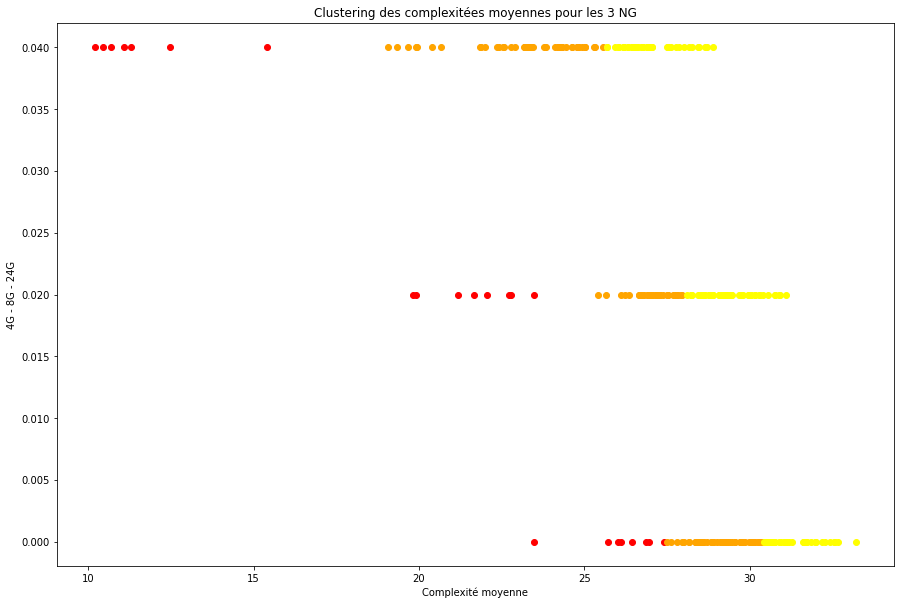

In [8]:
# Print figure avec superpositions des 3 NG pour pouvoir comparer
# Classe les points catégories complexités faible,moyenne ou forte

def affichage_clustering(n_cluster, pred_4, pred_8, pred_24):
  fig = plt.figure(figsize=(15,10))
  color = ['red', 'orange', 'yellow']
  for i in range(n_cluster):
    x4 = mean_complexity['4G'][pred_4==i]
    x8 = mean_complexity['8G'][pred_8==i]
    x24 = mean_complexity['24G'][pred_24==i]
    plt.scatter(x4, np.zeros_like(x4), color=color[i])
    plt.scatter(x8, np.ones(len(x8))*0.02, color=color[i])
    plt.scatter(x24, np.ones(len(x24))*0.04, color=color[i])
  plt.title('Clustering des complexitées moyennes pour les 3 NG')
  plt.xlabel('Complexité moyenne')
  plt.ylabel('4G - 8G - 24G')
  plt.show()


affichage_clustering(3, pred_4, pred_8, pred_24)

In [12]:
# Critère pour voir performance de cette méthode
# 1 - Pourcentage de personnes en chaque cluster :

def taux_clust(pred_4, pred_8, pred_24):
  tot = [len(mean_complexity['4G']), len(mean_complexity['8G']), len(mean_complexity['24G'])]

  tab_res = pd.DataFrame(np.array([[len(mean_complexity['4G'][pred_4==0])/tot[0],len(mean_complexity['8G'][pred_8==0])/tot[1], len(mean_complexity['24G'][pred_24==0])/tot[2]],
                                  [len(mean_complexity['4G'][pred_4==1])/tot[0],len(mean_complexity['8G'][pred_8==1])/tot[1], len(mean_complexity['24G'][pred_24==1])/tot[2]],
                                  [len(mean_complexity['4G'][pred_4==2])/tot[0],len(mean_complexity['8G'][pred_8==2])/tot[1], len(mean_complexity['24G'][pred_24==2])/tot[2]]]),
                        columns = ['4G','8G','24G'])
  return(tab_res)

gmm_rate = taux_clust(pred_4, pred_8, pred_24)
gmm_rate.head()

,4G,8G,24G
0,0.15,0.08,0.07
1,0.66,0.35,0.45
2,0.19,0.57,0.48


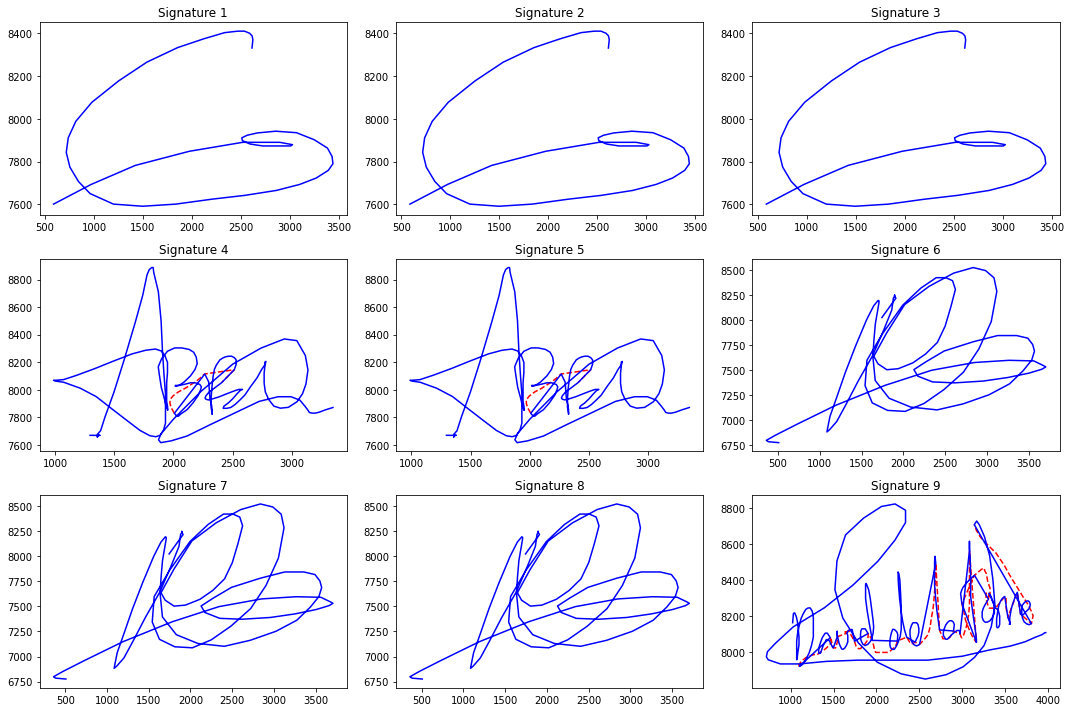

In [13]:
#Représentation de la classification
c_faible = [list(pred_4).index(0), list(pred_8).index(0), list(pred_24).index(0)]
c_moyenne = [list(pred_4).index(1), list(pred_8).index(1), list(pred_24).index(1)]
c_forte = [list(pred_4).index(2), list(pred_8).index(2), list(pred_24).index(2)]
classe = np.array([list(c_faible), list(c_moyenne), list(c_forte)]).reshape(9)


fig, axes = plt.subplots(3,3, figsize=(15,10))
for i,ax in enumerate(axes.flat):
  dt = pd.read_table('drive/MyDrive/Colab/Handwritten_sig/BD/{}v0.txt'.format(classe[i]), sep=' ', header=None)
  dt.columns = ['X', 'Y', 'P', 'Az', 'Al']
  dt_air = dt[dt['P'] == 0 ]
  dt_feuille = dt[dt['P'] != 0 ]
  ax.plot(dt_air['X'], dt_air['Y'], "r--")
  ax.plot(dt_feuille['X'], dt_feuille['Y'], "b")
  ax.set_title('Signature {}'.format(i+1))

#fig.suptitle('Signatures de la première personne', fontsize=16)
fig.tight_layout()

plt.show()
  



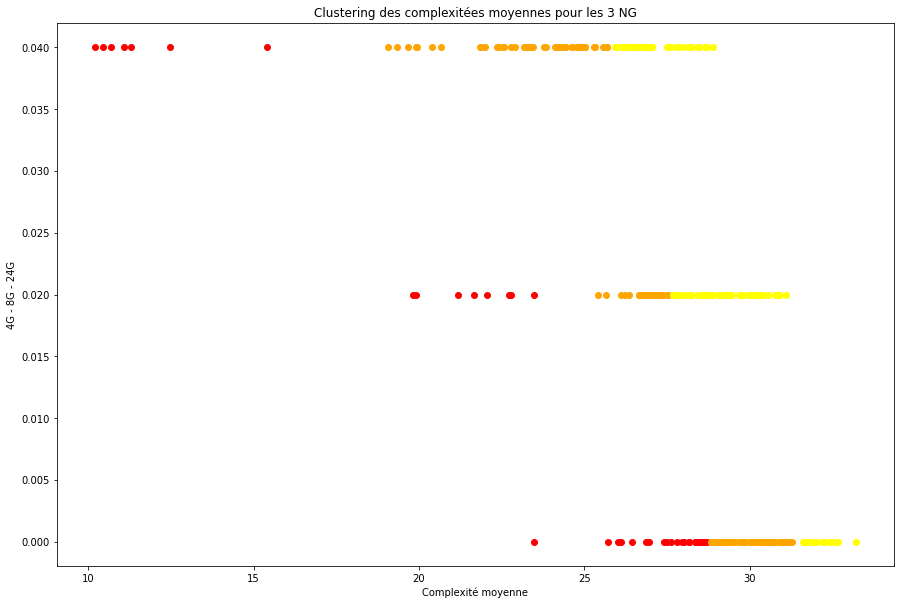

In [9]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode 2 : Classification ascendante (hierarchisation)

from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

y4 = AgglomerativeClustering(distance_threshold=None, n_clusters = 3).fit(dt4)
y8 = AgglomerativeClustering(distance_threshold=None, n_clusters = 3).fit(dt8)
y24 = AgglomerativeClustering(distance_threshold=None, n_clusters = 3).fit(dt24)

y_pred4 = AgglomerativeClustering(n_clusters = 3).fit_predict(dt4)
y_pred8 = AgglomerativeClustering(n_clusters = 3).fit_predict(dt8)
y_pred24 = AgglomerativeClustering(n_clusters = 3).fit_predict(dt24)

# Visualisation du résultat
order4, order8, order24 = order_prediction(3, y_pred4, y_pred8, y_pred24)
y_pred4, y_pred8, y_pred24 = (sort_clust(y_pred4, order4), sort_clust(y_pred8, order8), sort_clust(y_pred24, order24))
affichage_clustering(3, y_pred4, y_pred8, y_pred24)


In [15]:
CAH_rate = taux_clust(y_pred4, y_pred8, y_pred24)
CAH_rate.head()

,4G,8G,24G
0,0.26,0.08,0.07
1,0.57,0.29,0.52
2,0.17,0.63,0.41


IndexError: ignored

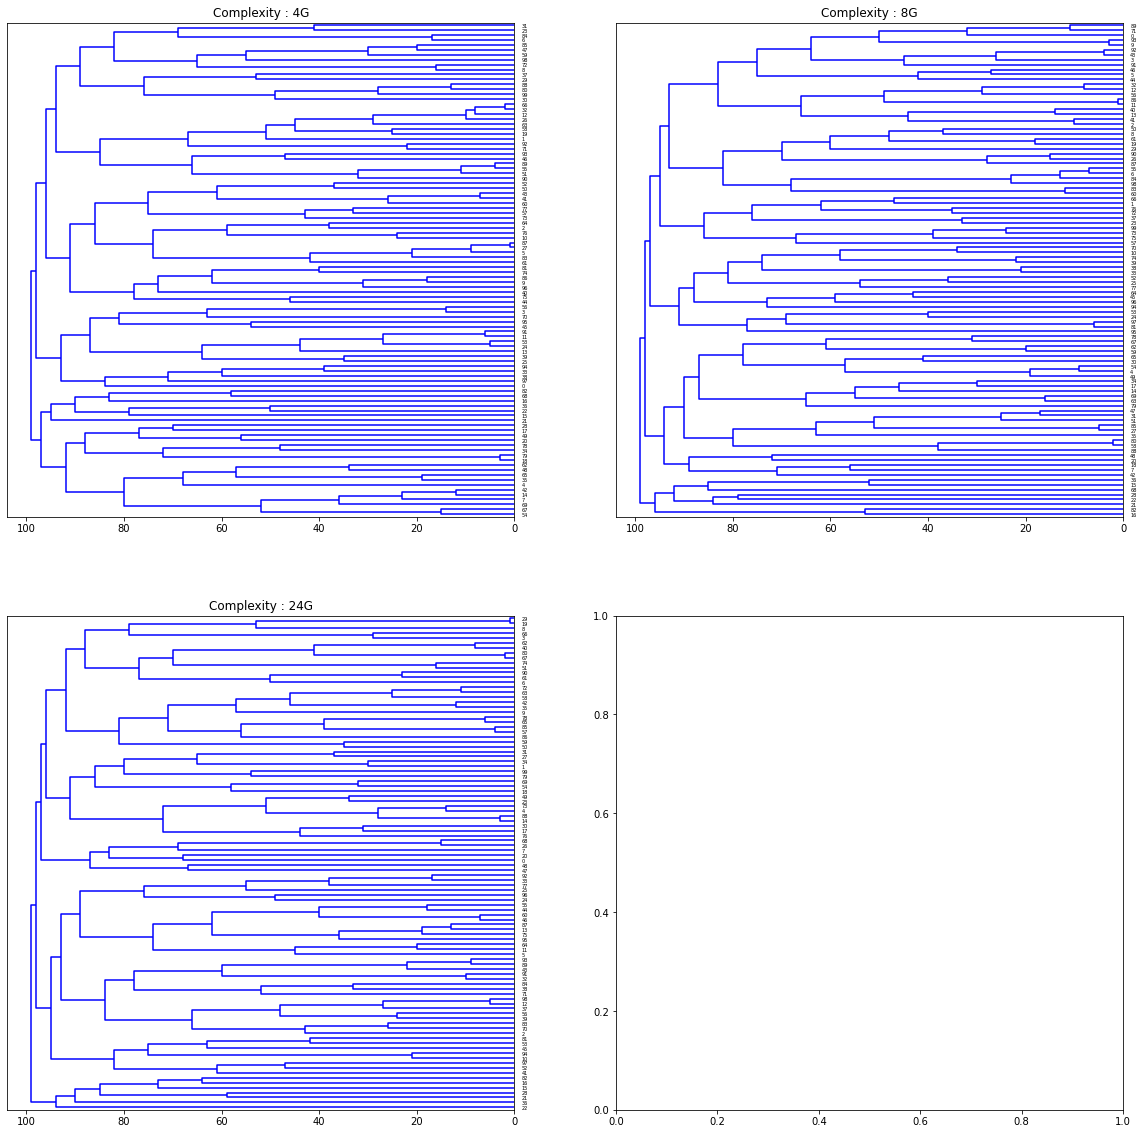

In [12]:
# Dendrogramme
# https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
from scipy.cluster.hierarchy import dendrogram
title = ['4G', '8G', '24G']

dendro4 = []
dendro8 = []
dendro24 = []

for i in range(len(y4.children_)):
    dendro4.append([y4.children_[i][0], y4.children_[i][1], float(len(dendro4)+1), len(dendro4)+1])
    dendro8.append([y8.children_[i][0], y8.children_[i][1], float(len(dendro8)+1), len(dendro8)+1])
    dendro24.append([y24.children_[i][0], y24.children_[i][1], float(len(dendro24)+1), len(dendro24)+1])

dendro = np.array([dendro4,dendro8,dendro24])
fig, axes = plt.subplots(2,2, figsize=(20,20))
for i,ax in enumerate(axes.flat):
  dendrogram(dendro[i], color_threshold=1, show_leaf_counts=True, ax=ax, orientation="left")
  ax.set_title('Complexity : {}'.format(title[i]))

Nombre de clusters estimés: [2, 2, 4]
Nombre de points bruités: [9, 12, 20]


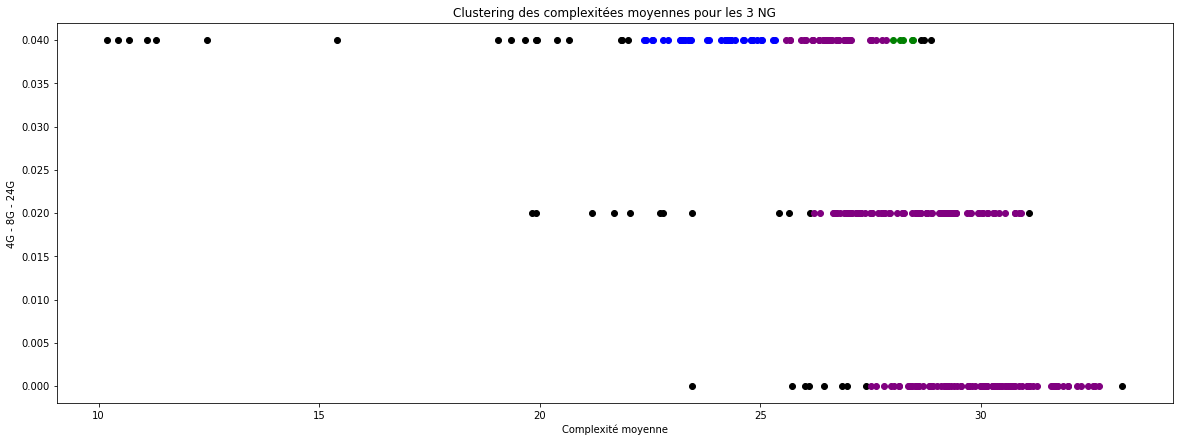

In [18]:
# Clasiffication des 100 personnes en 3 catégories
# Méthode suplémentaire pour vérifier si 3 clusters suffisent : DBSCAN
# Choisir les paramètres : https://askcodez.com/choisir-eps-et-minpts-pour-dbscan-r.html

from sklearn.cluster import DBSCAN

# Configuration
epsilon = 0.5
min_samples = 10

# DBSCAN
dbscan4 = DBSCAN(eps=epsilon, min_samples=min_samples).fit(dt4)
dbscan8 = DBSCAN(eps=epsilon, min_samples=min_samples).fit(dt8)
dbscan24 = DBSCAN(eps=epsilon, min_samples=min_samples).fit(dt24)
lab4 = dbscan4.labels_
lab8 = dbscan8.labels_
lab24 = dbscan24.labels_

no_clusters = [len(np.unique(lab4)),len(np.unique(lab8)), len(np.unique(lab24))]
no_noise = [np.sum(np.array(lab4) == -1, axis=0), np.sum(np.array(lab8) == -1, axis=0), np.sum(np.array(lab24) == -1, axis=0)]

print('Nombre de clusters estimés: {}'.format(no_clusters))
print('Nombre de points bruités: {}'.format(no_noise))

# Plot tout ça
fig = plt.figure(figsize=(20,7))
colors = [ 'black', 'purple', 'blue', 'green','red', 'orange', 'yellow']
for i in range(no_clusters[0]):
  x4 = mean_complexity['4G'][lab4==np.unique(lab4)[i]]
  plt.scatter(x4, np.zeros_like(x4), color=colors[i])
for i in range(no_clusters[1]):
  x8 = mean_complexity['8G'][lab8==np.unique(lab8)[i]]
  plt.scatter(x8, np.ones(len(x8))*0.02, color=colors[i])
for i in range(no_clusters[2]):
  x24 = mean_complexity['24G'][lab24==np.unique(lab24)[i]]
  plt.scatter(x24, np.ones(len(x24))*0.04, color=colors[i])

plt.title('Clustering des complexitées moyennes pour les 3 NG')
plt.xlabel('Complexité moyenne')
plt.ylabel('4G - 8G - 24G')
plt.show()


DBSCAN à analyser, comment définir paramètre ?
Nombre de cluster optimal? On ne peut pas definir nombre de clusters

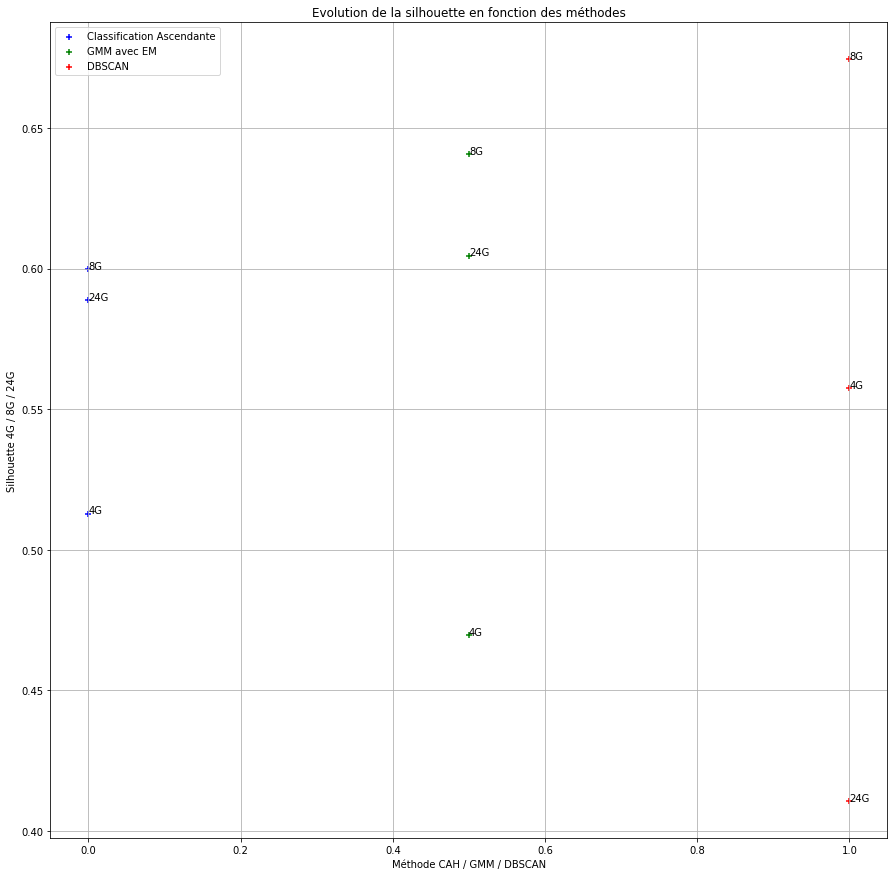

In [19]:
# Inertie intra et inter cluster avec les silhouettes

from scipy.spatial.distance import euclidean
from sklearn.metrics import silhouette_score


def get_sil(pred4, pred8, pred24):
  return([silhouette_score(dt4, pred4, metric = 'euclidean'), silhouette_score(dt8, pred8, metric = 'euclidean'), silhouette_score(dt24, pred24, metric = 'euclidean')])

  
sil_cah= get_sil(y_pred4, y_pred8, y_pred24)
sil_gmm = get_sil(pred_4, pred_8, pred_24)
sil_dbscan = get_sil(lab4, lab8, lab24)
annot = ['4G', '8G', '24G']

# Print l'évolution de la silhouette en fonction du nombre de clusters
fig, ax = plt.subplots(figsize=(15,15))
ax.scatter(np.zeros(3), sil_cah, marker='+', c='Blue', label='Classification Ascendante')
ax.scatter(np.ones(3)*0.5, sil_gmm, marker='+', c='Green', label='GMM avec EM')
ax.scatter(np.ones(3), sil_dbscan, marker='+', c='Red', label='DBSCAN')

# Annotate the points
for i,txt in enumerate(annot):
  ax.annotate(txt, (0, sil_cah[i]))
  ax.annotate(txt, (0.5, sil_gmm[i]))
  ax.annotate(txt, (1, sil_dbscan[i]))

ax.legend()
ax.grid()
plt.title('Evolution de la silhouette en fonction des méthodes')
plt.xlabel('Méthode CAH / GMM / DBSCAN')
plt.ylabel('Silhouette 4G / 8G / 24G')
plt.show()

Assez surprenant que silhouette ne soit pas maximale pour 24G cependant pour 24G on remarque que les clusters sont plus dispersés ainsi la distance intra clusters est plus importante ce qui peut expliquer cela (hyp)

In [20]:
# Représentant de chaque cluster pas assez appronfondie ! +
# conclusion du nombre de gaussiennes sur la précision du modèle GMM qui a servi au calcul de
#la mesure d’entropie différentielle et de la méthode de clustering sur la catégorisation des personnes. 



---


### <font color='PaleGreen'> B - Classification non-supervisées des signatures (writer-independent)</font>


Catégoriser les 2500 signatures authentiques en 3 clusters en se basant uniquement sur la
matrice « Complexité avec 24G (100x25) »

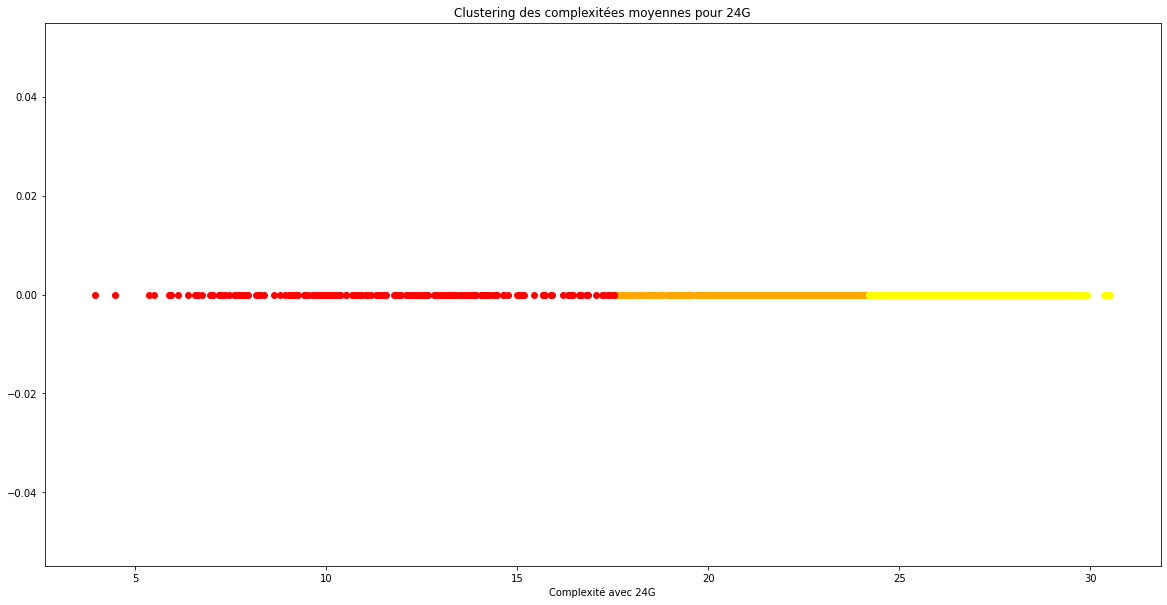

In [13]:
# Utilisation de GMM avec l'algo de l'EM avec 24G
# Catégorisation des 2500 signatures en 3 clusters

n_cluster = 3
test = [0]
#dt_sig = pd.read_table('drive/MyDrive/Colab/Handwritten_sig/BD/2v{}.txt'.format(i), sep=' ', header=None)


# Reshape pour avoir matrice 100*1 pour scale
dt_sig24 = np.array(complex_24G).reshape(2500,1)

# Distribution de moyenne 0 et de variance 1
scale24 = preprocessing.StandardScaler()

#Fit and transform data and reshape 2D array into 1D array
scaled_24 = scale24.fit_transform(dt_sig24)

gmm = GaussianMixture(n_components = n_cluster)
sig_pred24 = gmm.fit_predict(scaled_24)

fig = plt.figure(figsize=(20,10))
color = ['orange', 'red', 'yellow']
for i in range(n_cluster):
  plt.scatter(dt_sig24[sig_pred24==i], np.zeros(len(dt_sig24[sig_pred24==i])), color=color[i])
plt.title('Clustering des complexitées moyennes pour 24G')
plt.xlabel('Complexité avec 24G')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


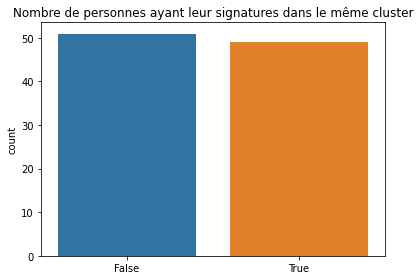

In [16]:
# 25 signatures d'une même personne toujours classées dans le même cluster ?
same_clust = np.array([len(set(sig_pred24.reshape(100,25)[i]))==1 for i in range(100)])
sns.countplot(same_clust)
plt.title('Nombre de personnes ayant leur signatures dans le même cluster')

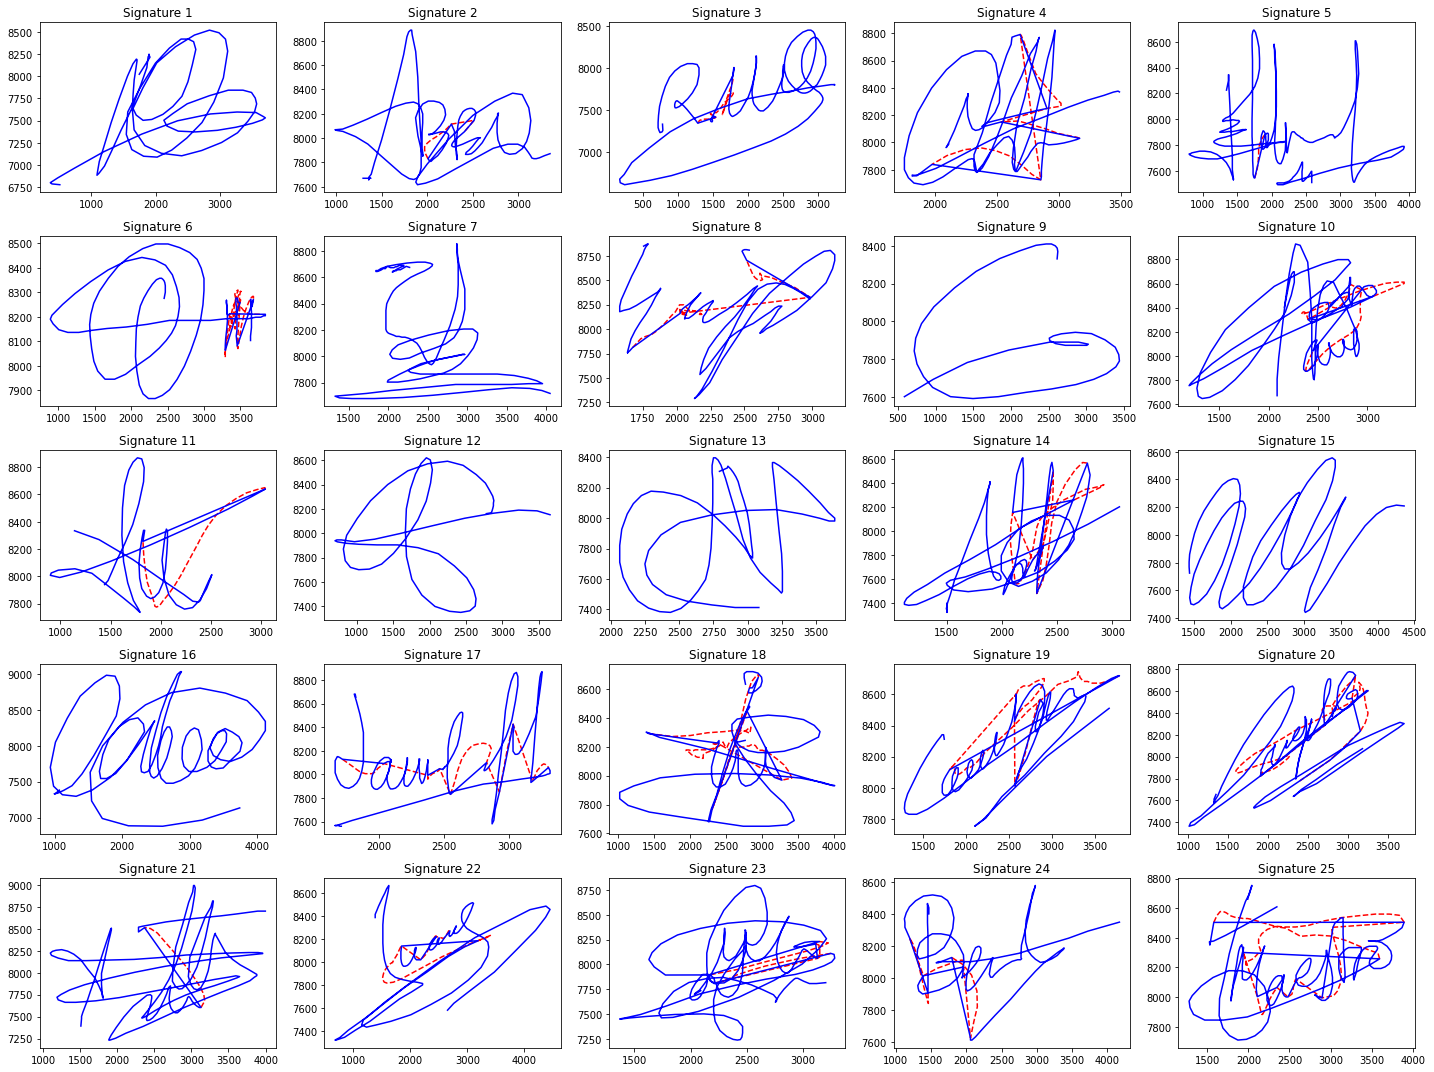

In [23]:
# Pour quel type de signatures observez-vous une variabilité dans la catégorisation de leurs signatures ?

sig_var = np.where(same_clust==False)[0]
fig, axes = plt.subplots(5,5, figsize=(20,15))
for i,ax in enumerate(axes.flat):
  dt = pd.read_table('drive/MyDrive/Colab/Handwritten_sig/BD/{}v0.txt'.format(sig_var[i]), sep=' ', header=None)
  dt.columns = ['X', 'Y', 'P', 'Az', 'Al']
  dt_air = dt[dt['P'] == 0 ]
  dt_feuille = dt[dt['P'] != 0 ]
  ax.plot(dt_air['X'], dt_air['Y'], "r--")
  ax.plot(dt_feuille['X'], dt_feuille['Y'], "b")
  ax.set_title('Signature {}'.format(i+1))

fig.tight_layout()

plt.show()
  


In [24]:
# Remarquez-vous l’apparition de données aberrantes pour certaines personnes ?
'''JSP à voir'''

'JSP à voir'

15    10.691394
16    10.200076
21    11.297201
22    15.410524
28    11.087322
36    12.460725
82    10.441122
Name: 24G, dtype: float64


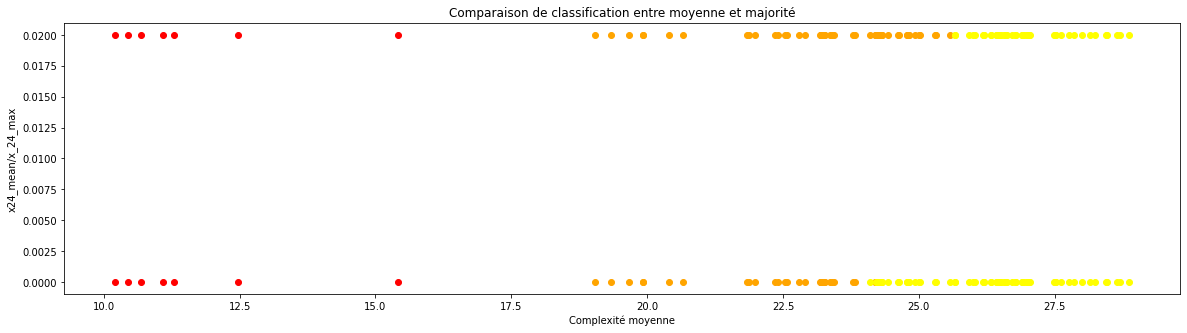

In [32]:
# Pourrions-nous classer les individus en s’appuyant sur les mesures de complexité de chacune de leurs signatures (et non la moyenne) ?

'''Si classification vraie selon les signatures d'une même personne, on peut classer la personne dans le cluster qui correspond au cluster 
dans lequel le nombre de ses signatures est maximal'''

res = sig_pred24.reshape(100,25)
classif_max = np.array([np.argmax(np.bincount(res[i])) for i in range(100)])

# Comparaison entre max et la moyenne pour 24G gmm
n_cluster = 3
fig = plt.figure(figsize=(20,5))
color = ['red', 'orange', 'yellow']
colors = ['orange', 'red', 'yellow']
for i in range(n_cluster):
  x24_max = mean_complexity['24G'][classif_max==i]
  x24_mean = mean_complexity['24G'][pred_24==i]
  plt.scatter(x24_max, np.zeros(len(x24_max)), color=colors[i])
  plt.scatter(x24_mean, np.ones(len(x24_mean))*0.02, color=color[i])
plt.title('Comparaison de classification entre moyenne et majorité')
plt.xlabel('Complexité moyenne')
plt.ylabel('x24_mean/x_24_max')
plt.show()



---


### <font color='PaleGreen'>C - Partie Apprentissage et généralisation </font>

Catégoriser les 2500 signatures authentiques en 3 clusters en se basant uniquement sur la matrice « Complexité avec 24G (100x25) » et en divisant la base en deux parties égales (1250 pour identifier les représentants des clusters et 1250 calcul de distance aux représentants). 


In [110]:
# 1ère approche : Choix des 1250 signatures de façon aléatoire
# Mélange aléatoire puis split des données en 2 datasets
dt_sig24_rand = dt_sig24.reshape(1,-1)[0]
np.random.shuffle(dt_sig24_rand)
data_1, data_2 = np.split(dt_sig24_rand, 2)

In [111]:
from sklearn.neighbors import KNeighborsClassifier

# Classification des données du premier dataset
n_cluster = 3
gmm = GaussianMixture(n_components = n_cluster)
pred1 = gmm.fit_predict(data_1.reshape(-1,1))

# Choix des représentants par moyenne de chaque cluster
val_c0 = data_1[pred1==0]
val_c1 = data_1[pred1==1]
val_c2 = data_1[pred1==2]
mean_0, mean_1, mean_2 = map(lambda x:np.mean(x), [val_c0, val_c1, val_c2])

# Classification du reste des données dans les clusters précedents par méthode de KNN (généralisation)
#p=2 =>Manhanttan distance et p=1 =>euclidian distance
#kNN = KNeighborsClassifier(n_neighbors=2, p=2, algorithm='auto').fit(data_2.reshape(-1,1), pred1)
#pred2 = kNN.predict(data_2.reshape(-1,1))


pred2 = np.array([list(map(lambda x: np.argmin(np.array([np.linalg.norm(mean_0-x),np.linalg.norm(mean_1-x),np.linalg.norm(mean_2-x)])),data_2))])[0]
pred3 = np.hstack((pred1, pred2))

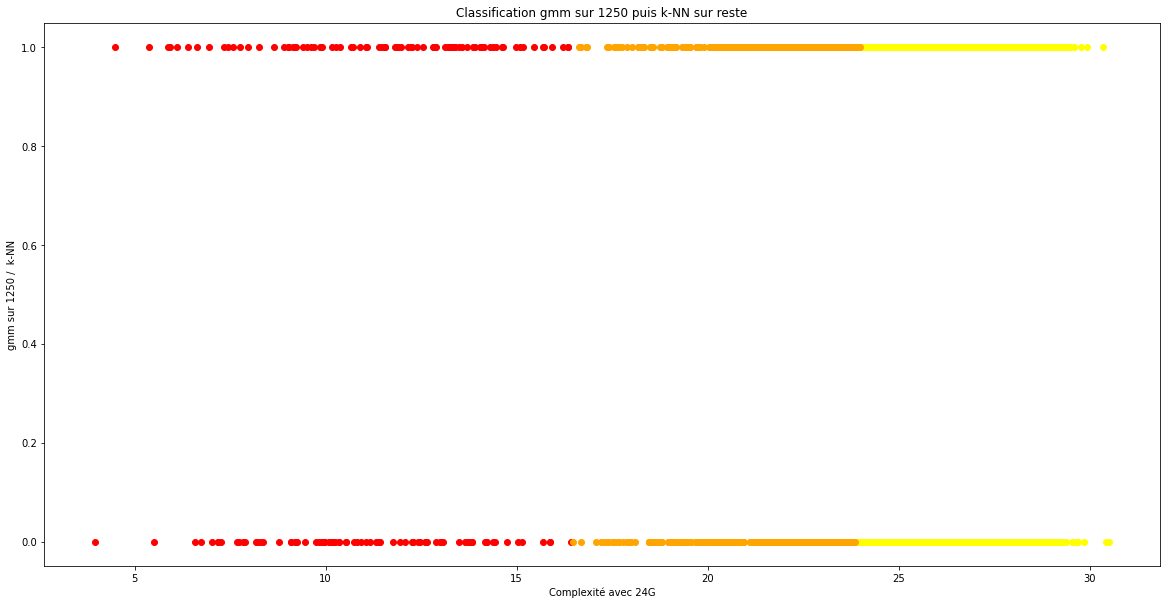

In [112]:
# Comparaison par rapport classification de la QUESTION 2
fig = plt.figure(figsize=(20,10))
color = ['yellow', 'red', 'orange']
for i in range(n_cluster):
  plt.scatter(data_1[pred1==i], np.zeros(len(data_1[pred1==i])), color=color[i])
  plt.scatter(data_2[pred2==i], np.ones(len(data_2[pred2==i])), color=color[i])
plt.title('Classification gmm sur 1250 puis k-NN sur reste')
plt.xlabel('Complexité avec 24G')
plt.ylabel('gmm sur 1250 /  k-NN')
plt.show()

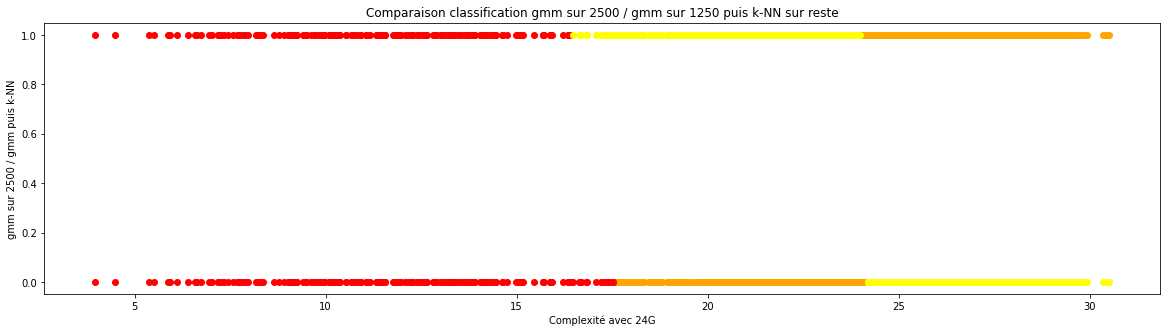

In [113]:
# Comparaison par rapport classification de la QUESTION 2
dt_sig24 = np.array(complex_24G).reshape(2500,1)
fig = plt.figure(figsize=(20,5))
color = ['orange', 'red', 'yellow']
for i in range(n_cluster):
  plt.scatter(dt_sig24_rand[pred3==i], np.ones(len(dt_sig24_rand[pred3==i])), color=color[i])
  plt.scatter(dt_sig24[sig_pred24==i], np.zeros(len(dt_sig24[sig_pred24==i])), color=color[i])
plt.title('Comparaison classification gmm sur 2500 / gmm sur 1250 puis k-NN sur reste')
plt.xlabel('Complexité avec 24G')
plt.ylabel('gmm sur 2500 / gmm puis k-NN')
plt.show()

In [75]:
# DEBILE PRC CLASSIF SUR DES DONN2ES DEJA CLASSE AVEC GMM ?! a voir

print(dt_sig24.reshape(1,2500))
# 1ère approche : Choix des 1250 signatures de façon proportionné pour chaque clusters (tjrs avec méthode gmm)
val_c0 = dt_sig24[sig_pred24==0].reshape(1,-1)[0]
val_c1 = dt_sig24[sig_pred24==1].reshape(1,-1)[0]
val_c2 = dt_sig24[sig_pred24==2].reshape(1,-1)[0]
print(len(val_c0), len(val_c1)/2, len(val_c2)/2)

# 3 clusters pour identifier les représentants des clusters
clust0_0, clust1_0, clust2_0 = np.random.choice(val_c0, len(val_c0)//2+1), np.random.choice(val_c1, len(val_c1)//2), np.random.choice(val_c2, len(val_c2)//2)

mean_0, mean_1, mean_2 = map(lambda x:np.mean(x), [clust0_0, clust1_0, clust2_0])
print(mean_0, mean_1, mean_2)

# 3 autres clusters pour calculer les distances aux représentants
clust0_1, clust1_1, clust2_1 = np.delete(dt_sig24[sig_pred24==0], np.where(clust0_0)), np.delete(dt_sig24[sig_pred24==1], np.where(clust1_0)), np.delete(dt_sig24[sig_pred24==2], np.where(clust2_0))




[[19.41837917 21.16804097 17.97811414 ... 22.4602686  20.61011107
  20.7058419 ]]
729 90.5 795.0
22.022089127175498 11.804805021957112 26.330277191730104
